<a href="https://colab.research.google.com/github/davemcg/scEiaD/blob/colab/Query_scEiaD_with_scVI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Querying scEiaD with scVI

## tldr 

You can take your (retina) scRNA and overlay it onto [our](https://plae.nei.nih.gov) scEiaD (single cell Eye in a Disk) with minimuim fuss. This allows you to:

## more reading
1. Quickly check whether your sequencing worked (if most of your cells lay outside the known retina cell types...then likely something went wrong)
2. Quickly see whether the cell types of the retina that you expect are present   
  - a pan-retina scRNA will have very different proportions of the retinal cell types than a flow-sorted (for some marker) experiment
3. Label your cell types by looking for overlaps between scEiaD and your data
  - In the future we will also share our xgboost model so you can auto-label your data with our highly trained xgboost-based machine learning model. 

## What does scVI do?
Very briefly, the raw cell x gene expression counts (labelled only with the study/batch covariate) are given to scVI, which uses a [VAE](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73) to model the counts. The model can output batch corrected "latent dimensions" which are the equivalent of running a PCA on the counts.

The scVI latent dimensions can be fed into the scanpy/Seurat/etc clustering/UMAP tools. 

A recent (version >= 0.8.0) update to scVI uses the "scArches" approach to encode the batches in a way that allows the model to be re-used with *new* data (that the scVI model has never seen). 

The Yosef Lab folks use the "reference" and "query" terms. In this case, reference is the scVI model built for scEiaD. Query is outside data. If you query (or project) your data with the scVI/scEiaD model, then you will get a set of latent dimensions that you use to make a UMAP visualization that will closely approximate the one hosted at https://plae.nei.nih.gov


## Overview
1. Install scvi and kallisto-bustools
2. Download:
  - our kallisto index
  - our scVI model
  - mini versions of the scEiaD
4. Quantify SRA sample `SRR12130660` with kallisto-bustools
5. Preprocess the h5ad object and glue scEiaD with SRR12130660
6. Querying SRA dataset `SRR12130660` (merged with the scEiaD data) with scVI
7. Visualize Result
8. Export result for Seurat usage




# Install scvi and kallisto-bustools

In [1]:
import sys
import re
#if True, will install via pypi, else will install from source
stable = True
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB and stable:
    !pip install --quiet scvi-tools[tutorials]==0.8.0
elif IN_COLAB and not stable:
    !pip install --quiet --upgrade jsonschema
    !pip install --quiet git+https://github.com/yoseflab/scvi-tools@master#egg=scvi-tools[tutorials]

!pip install --quiet kb-python


     |████████████████████████████████| 153kB 13.1MB/s 
     |████████████████████████████████| 184kB 34.1MB/s 
     |████████████████████████████████| 245kB 48.0MB/s 
     |████████████████████████████████| 122kB 51.4MB/s 
     |████████████████████████████████| 3.2MB 54.0MB/s 
     |████████████████████████████████| 51kB 8.7MB/s 
     |████████████████████████████████| 7.7MB 33.4MB/s 
     |████████████████████████████████| 2.4MB 52.5MB/s 
     |████████████████████████████████| 8.7MB 46.9MB/s 
     |████████████████████████████████| 51kB 8.3MB/s 
     |████████████████████████████████| 112kB 55.4MB/s 
     |████████████████████████████████| 71kB 10.8MB/s 
     |████████████████████████████████| 51kB 8.6MB/s 
     |████████████████████████████████| 59.1MB 50kB/s 
     |████████████████████████████████| 13.2MB 262kB/s 


# Optional! Download our kallisto index
As our example set is mouse, we use the mouse Gencode vM25 transcript reference.

Nothing funky was done to make it, but the index creation requires around 32GB of memory, so it cannot be done in colab. Plus it takes 30 minutes or so. 

The index was created with this command:

`kallisto index gencode.vM25.transcripts.fa.gz -i gencode.vM25.transcripts.idx`

The transcript 2 gene file was made with this command:

`zgrep "^>" gencode.vM25.transcripts.fa.gz | sed 's/>//g' | awk 'BEGIN {OFS = "\t"; FS = "|"}; {print $0, $2, $2}' > vM25.tr2g.tsv`

(Our human kallisto idx and tr2g are here):
```
https://hpc.nih.gov/~mcgaugheyd/scEiaD/colab/gencode.v35.transcripts.idx
https://hpc.nih.gov/~mcgaugheyd/scEiaD/colab/v35.tr2g.tsv
```

If you want to skip the kallisto quant (~5 minutes) then you can skip a few chunks below to where we load the h5ad object for the query (non scEiaD) data.

In [2]:
%%time
!wget -O idx.idx https://hpc.nih.gov/~mcgaugheyd/scEiaD/colab/gencode.vM25.transcripts.idx
!wget -O t2g.txt https://hpc.nih.gov/~mcgaugheyd/scEiaD/colab/vM25.tr2g.tsv

--2021-01-07 17:06:24--  https://hpc.nih.gov/~mcgaugheyd/scEiaD/colab/gencode.vM25.transcripts.idx
Resolving hpc.nih.gov (hpc.nih.gov)... 128.231.2.150, 2607:f220:418:4801::2:96
Connecting to hpc.nih.gov (hpc.nih.gov)|128.231.2.150|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2662625893 (2.5G) [application/octet-stream]
Saving to: ‘idx.idx’

idx.idx             100%[===================>]   2.48G  34.9MB/s    in 39s     

2021-01-07 17:07:05 (65.4 MB/s) - ‘idx.idx’ saved [2662625893/2662625893]

--2021-01-07 17:07:09--  https://hpc.nih.gov/~mcgaugheyd/scEiaD/colab/vM25.tr2g.tsv
Resolving hpc.nih.gov (hpc.nih.gov)... 128.231.2.150, 2607:f220:418:4801::2:96
Connecting to hpc.nih.gov (hpc.nih.gov)|128.231.2.150|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23498117 (22M) [application/octet-stream]
Saving to: ‘t2g.txt’

t2g.txt             100%[===================>]  22.41M   128MB/s    in 0.2s    

2021-01-07 17:07:10 (128 MB/s) - ‘t

# Optional! Quantify with kbtools (Kallisto - Bustools wrapper) in one easy step.

Going into the vagaries of turning a SRA deposit into a non-borked pair of fastq files is beyond the scope of this document. Plus I would swear a lot. So we just give an example set from a Mouse retina 10x (version 2) experiment.

The Pachter Lab has a discussion of how/where to get public data here: https://colab.research.google.com/github/pachterlab/kallistobustools/blob/master/notebooks/data_download.ipynb

If you have your own 10X bam file, then 10X provides a very nice and simple tool to turn it into fastq file here: https://github.com/10XGenomics/bamtofastq

To reduce run-time we have taken the first five million reads from this fastq pair.

This will take ~3 minute, depending on the internet speed between Google and our fastq

You can also directly stream the file, but I was getting periodic errors, so we are doing the simpler thing and downloading each fastq file here first.

 

In [3]:
%%time
!wget -O sample_1.fastq.gz https://hpc.nih.gov/~mcgaugheyd/scEiaD/colab/SRR12130660_1.head.fastq.gz
!wget -O sample_2.fastq.gz https://hpc.nih.gov/~mcgaugheyd/scEiaD/colab/SRR12130660_2.head.fastq.gz
!kb count --overwrite --h5ad -i idx.idx -g t2g.txt -x 10xv2 -o output --filter bustools -t 2 \
  sample_1.fastq.gz \
  sample_2.fastq.gz

--2021-01-07 17:07:10--  https://hpc.nih.gov/~mcgaugheyd/scEiaD/colab/SRR12130660_1.head.fastq.gz
Resolving hpc.nih.gov (hpc.nih.gov)... 128.231.2.150, 2607:f220:418:4801::2:96
Connecting to hpc.nih.gov (hpc.nih.gov)|128.231.2.150|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 123045723 (117M) [application/octet-stream]
Saving to: ‘sample_1.fastq.gz’

sample_1.fastq.gz   100%[===================>] 117.34M   148MB/s    in 0.8s    

2021-01-07 17:07:11 (148 MB/s) - ‘sample_1.fastq.gz’ saved [123045723/123045723]

--2021-01-07 17:07:11--  https://hpc.nih.gov/~mcgaugheyd/scEiaD/colab/SRR12130660_2.head.fastq.gz
Resolving hpc.nih.gov (hpc.nih.gov)... 128.231.2.150, 2607:f220:418:4801::2:96
Connecting to hpc.nih.gov (hpc.nih.gov)|128.231.2.150|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 276834766 (264M) [application/octet-stream]
Saving to: ‘sample_2.fastq.gz’

sample_2.fastq.gz   100%[===================>] 264.01M   112MB/s    in 2.4s


# Download our scEiaD anndata objects and scVI model

scVI was run on a human-only subset of the data. The mouse and macaque data were projected onto it. So thus we will provide two (mini*) anndata objects: the human reference data ("ref") and the mouse/macaque data ("query").

We will later glue the totally new data (SRR12130660) onto the query anndata object.

\* 12GB max memory usage here!

In [4]:
%%time
import scvi
import scanpy as sc
import pandas as pd 
#sc.set_figure_params(figsize=(8, 8))

!wget -O scEiaD_ref.h5ad https://hpc.nih.gov/~mcgaugheyd/scEiaD/colab/scEiaD_all_anndata_mini_ref.h5ad
!wget -O scEiaD_query.h5ad https://hpc.nih.gov/~mcgaugheyd/scEiaD/colab/scEiaD_all_anndata_mini_query.h5ad
adata_scEiaD_ref = sc.read_h5ad('scEiaD_ref.h5ad')
adata_scEiaD_query = sc.read_h5ad('scEiaD_query.h5ad')

# Download the scEiaD scVI model and untar
!wget -O 2021_01_03__scVI_scEiaD.tgz https://hpc.nih.gov/~mcgaugheyd/scEiaD/2021_01_03/2021_01_03__scVI_scEiaD.tgz
!tar -xzf 2021_01_03__scVI_scEiaD.tgz
# Set scVI model path
scVI_model_dir_path = 'scVIprojectionSO_scEiaD_model/n_features-5000__transform-counts__partition-universe__covariate-batch__method-scVIprojectionSO__dims-8_query'
# Read in HVG genes used in scVI model
var_names = pd.read_csv(scVI_model_dir_path + '/var_names.csv', header = None)

--2021-01-07 17:09:03--  https://hpc.nih.gov/~mcgaugheyd/scEiaD/colab/scEiaD_all_anndata_mini_ref.h5ad
Resolving hpc.nih.gov (hpc.nih.gov)... 128.231.2.150, 2607:f220:418:4801::2:96
Connecting to hpc.nih.gov (hpc.nih.gov)|128.231.2.150|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 118980930 (113M) [application/octet-stream]
Saving to: ‘scEiaD_ref.h5ad’

scEiaD_ref.h5ad     100%[===================>] 113.47M   138MB/s    in 0.8s    

2021-01-07 17:09:04 (138 MB/s) - ‘scEiaD_ref.h5ad’ saved [118980930/118980930]

--2021-01-07 17:09:04--  https://hpc.nih.gov/~mcgaugheyd/scEiaD/colab/scEiaD_all_anndata_mini_query.h5ad
Resolving hpc.nih.gov (hpc.nih.gov)... 128.231.2.150, 2607:f220:418:4801::2:96
Connecting to hpc.nih.gov (hpc.nih.gov)|128.231.2.150|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 173326183 (165M) [application/octet-stream]
Saving to: ‘scEiaD_query.h5ad’

scEiaD_query.h5ad   100%[===================>] 165.30M   139MB/s   

# Load SRR12130660 h5ad
If you ran kallisto quant above, then this is where you load the SRR12130660 data as an anndata object. 

Alternatively, you can just load the SRR12130660 h5ad output that we pre-ran for you. (see code block below)



In [5]:
# uncomment (delete the leading "#") the two lines below if you want to use our precomputed h5ad object which was created with the full SRR12130660 fastq pair
#!mkdir -p output/counts_filtered/
#!wget -O output/counts_filtered/adata.h5ad https://hpc.nih.gov/~mcgaugheyd/scEiaD/colab/adata_SRR12130660.h5ad

adata_query = sc.read_h5ad('output/counts_filtered/adata.h5ad')
adata_query

AnnData object with n_obs × n_vars = 1157 × 55401
    var: 'gene_name'

# Some futzing required

The scVI model was built on human data, with human ensembl IDs (e.g. ENSG00000105392).

So we have to convert our ensembl *mouse* IDs to *human* as scVI requires the exact same genes (names) to be used. 



In [6]:
conversion_table = pd.read_csv('https://hpc.nih.gov/~mcgaugheyd/scEiaD/colab/ensembl_biomart_human2mouse_macaque.tsv', 
 sep = '\t', 
 header=0,
 names= ['human_gene_id', 'verisioned_hid','mouse_gene_id', 'macaque_gene_id', 'gene_name', 'mouse_gene_name', 'maca_gene_name'])
conversion_table
ctab = pd.DataFrame({'mouse_id_versioned': adata_query.var_names}) 
ctab = ctab.assign(mouse_gene_id = ctab.mouse_id_versioned.str.replace('\.\d+$', ''))
ctab = ctab.merge(right = conversion_table, how='inner', on = 'mouse_gene_id')
ctab = ctab.loc[:,['mouse_id_versioned', 'human_gene_id']].drop_duplicates(subset=['human_gene_id']).drop_duplicates(subset=['mouse_id_versioned'])
adata_renamed =adata_query[:,ctab['mouse_id_versioned']].copy() 
adata_renamed.var_names = ctab['human_gene_id']


If some of the HVG were not quantified they would be missing, so just in case we add any missing back with all zero for expression.

In [7]:
import anndata
import numpy as np
present = [x not in adata_renamed.var_names for x in var_names[0]]
msg=var_names[0][present]
empty_ad = anndata.AnnData(np.zeros((adata_renamed.shape[0], len(msg)) ))
empty_ad.var_names=msg
rn = ['c'+str(i) for i in range(adata_renamed.shape[0])]
empty_ad.obs_names=rn 
adata_renamed.obs_names = rn
adata_query = anndata.concat([adata_renamed, empty_ad], axis=1).copy()

# Glue together scEiaD query and the SRR12130660 query data
scVI requires *only* the genes used to train the model to be in the anndata object. So we will cut down the anndata object `_HVG` for the scVI machine learning parts. 

In [8]:
adata_query.obs['batch'] = 'SRR12130660'
adata_query.obs['query'] = 'SRR12130660'
adata_query.obs['CellType_predict'] = 'SRR12130660'
adata_scEiaD_ref.obs['query'] = 'scEiaD'
adata_scEiaD_query.obs['query'] = 'scEiaD'

# HVG only to merge
adata_scEiaD_query_HVG = adata_scEiaD_query[:, var_names[0]]
adata_query_HVG = adata_query[:, var_names[0]].copy()
adata_query_HVG = adata_query.concatenate(adata_scEiaD_query, batch_key='bkey')


In [9]:
# intialize for scVI run
adata_query_HVG = adata_query_HVG[:, var_names[0]].copy()
scvi.data.setup_anndata(adata_query_HVG, batch_key="batch")

INFO     Using batches from adata.obs["batch"]                                  
INFO     No label_key inputted, assuming all cells have same label              
INFO     Using data from adata.X                                                


/usr/local/lib/python3.6/dist-packages/scvi/data/_anndata.py:711: UserWarning: Category 57 in adata.obs['_scvi_batch'] has fewer than 3 cells. SCVI may not train properly.
  category, alternate_column_key


INFO     Computing library size prior per batch                                 
INFO     Successfully registered anndata object containing 23324 cells, 5000    
         vars, 76 batches, 1 labels, and 0 proteins. Also registered 0 extra    
         categorical covariates and 0 extra continuous covariates.              
INFO     Please do not further modify adata until model is trained.             


# Set up the scVI model
Load the model (via `scVI_model_dir_path`) and feed it the anndata object we have been working on during this document

In [10]:
vae_query = scvi.model.SCVI.load_query_data(
    adata_query_HVG, 
    scVI_model_dir_path,
    use_cuda = True,
)

INFO     Using data from adata.X                                                
INFO     Computing library size prior per batch                                 


/usr/local/lib/python3.6/dist-packages/scvi/data/_anndata.py:711: UserWarning: Category 11 in adata.obs['_scvi_batch'] has fewer than 3 cells. SCVI may not train properly.
  category, alternate_column_key


INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var',  
         'labels']                                                              
INFO     Successfully registered anndata object containing 23324 cells, 5000    
         vars, 88 batches, 1 labels, and 0 proteins. Also registered 0 extra    
         categorical covariates and 0 extra continuous covariates.              


# Run scVI
The scVI folks recommend more epochs, but 5 will get you most of the way there in a very short amount of time. 

In [11]:
vae_query.train(n_epochs = 5, weight_decay=0.0)

INFO     Training for 5 epochs                                                  
INFO     KL warmup phase exceeds overall training phaseIf your applications rely
         on the posterior quality, consider training for more epochs or reducing
         the kl warmup.                                                         
INFO     KL warmup for 400 epochs                                               
Training...:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.6/dist-packages/scvi/core/distributions/_negative_binomial.py:434: UserWarning: The value argument must be within the support of the distribution
  UserWarning,


Training...: 100%|██████████| 5/5 [00:07<00:00,  1.55s/it]
INFO     Training is still in warming up phase. If your applications rely on the
         posterior quality, consider training for more epochs or reducing the kl
         warmup.                                                                
INFO     Training time:  7 s. / 5 epochs                                        


# Extract latent dimensions with newly trained model
Then glue together the ref and query anndata objects for UMAP making below

In [12]:
#adata_query.obsm['X_scvi'] = vae_query.get_latent_representation()
adata_scEiaD_ref_HVG = adata_scEiaD_ref[:,var_names[0]].copy()

#scvi.data.setup_anndata(adata_scEiaD_ref_HVG, batch_key="batch")
adata_scEiaD_ref_HVG.obsm['X_scvi'] = vae_query.get_latent_representation(adata_scEiaD_ref_HVG)
adata_query_HVG.obsm['X_scvi'] = vae_query.get_latent_representation(adata_query_HVG)
adata_full_HVG = adata_query_HVG.concatenate(adata_scEiaD_ref_HVG, batch_key = 'bkey')


INFO     Input adata not setup with scvi. attempting to transfer anndata setup  
INFO     .obs[_scvi_labels] not found in target, assuming every cell is same    
         category                                                               
INFO     Using data from adata.X                                                
INFO     Computing library size prior per batch                                 


/usr/local/lib/python3.6/dist-packages/scvi/data/_anndata.py:795: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  logger_data_loc


INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var',  
         'labels']                                                              
INFO     Successfully registered anndata object containing 27350 cells, 5000    
         vars, 88 batches, 1 labels, and 0 proteins. Also registered 0 extra    
         categorical covariates and 0 extra continuous covariates.              
WARNING  Training will be faster when sparse matrix is formatted as CSR. It is  
         safe to cast before model initialization.                              
WARNING  Make sure the registered X field in anndata contains unnormalized count
         data.                                                                  


# Copy over the batch corrected latent dimensions
We put them back into the anndata object, then run neighbor finding and umap dimensionality reduction.

In [13]:
#adata_full.obsm['X_scvi'] = vae_query.get_latent_representation(adata_scEiaD_HVG)
sc.pp.neighbors(adata_full_HVG, n_neighbors=10, use_rep = 'X_scvi')
sc.tl.umap(adata_full_HVG, min_dist=0.2)

# Plotting
First plot shows the labelled cells from scEiaD *and* (in dark pink?) the new dataset SRR12130660.

The second plot shows only SRR12130660.

The third plot shows scEiaD in orange and SRR12130660 in blue. 

We see how SRR12130660 has a bunch of rods, muller glia, amacrine, and retinal ganglion. Maybe a few cones (mice don't have many cones). A few "retina-adjacent" endothelial and blood cells. 


... storing 'batch' as categorical
... storing 'query' as categorical
... storing 'CellType_predict' as categorical
... storing 'study_accession' as categorical
... storing 'TechType' as categorical
... storing 'SA' as categorical
... storing 'Barcode' as categorical
... storing 'Phase' as categorical
... storing 'sample_accession' as categorical
... storing 'library_layout' as categorical
... storing 'organism' as categorical
... storing 'Platform' as categorical
... storing 'UMI' as categorical
... storing 'Tissue' as categorical
... storing 'Covariate' as categorical
... storing 'integration_group' as categorical
... storing 'TissueNote' as categorical
... storing 'CellType' as categorical
... storing 'Paper' as categorical
... storing 'SubCellType' as categorical
... storing 'barcode' as categorical
... storing 'donor' as categorical
... storing 'region' as categorical
... storing 'Method' as categorical
... storing 'Doublet' as categorical
... storing 'sample' as categorical


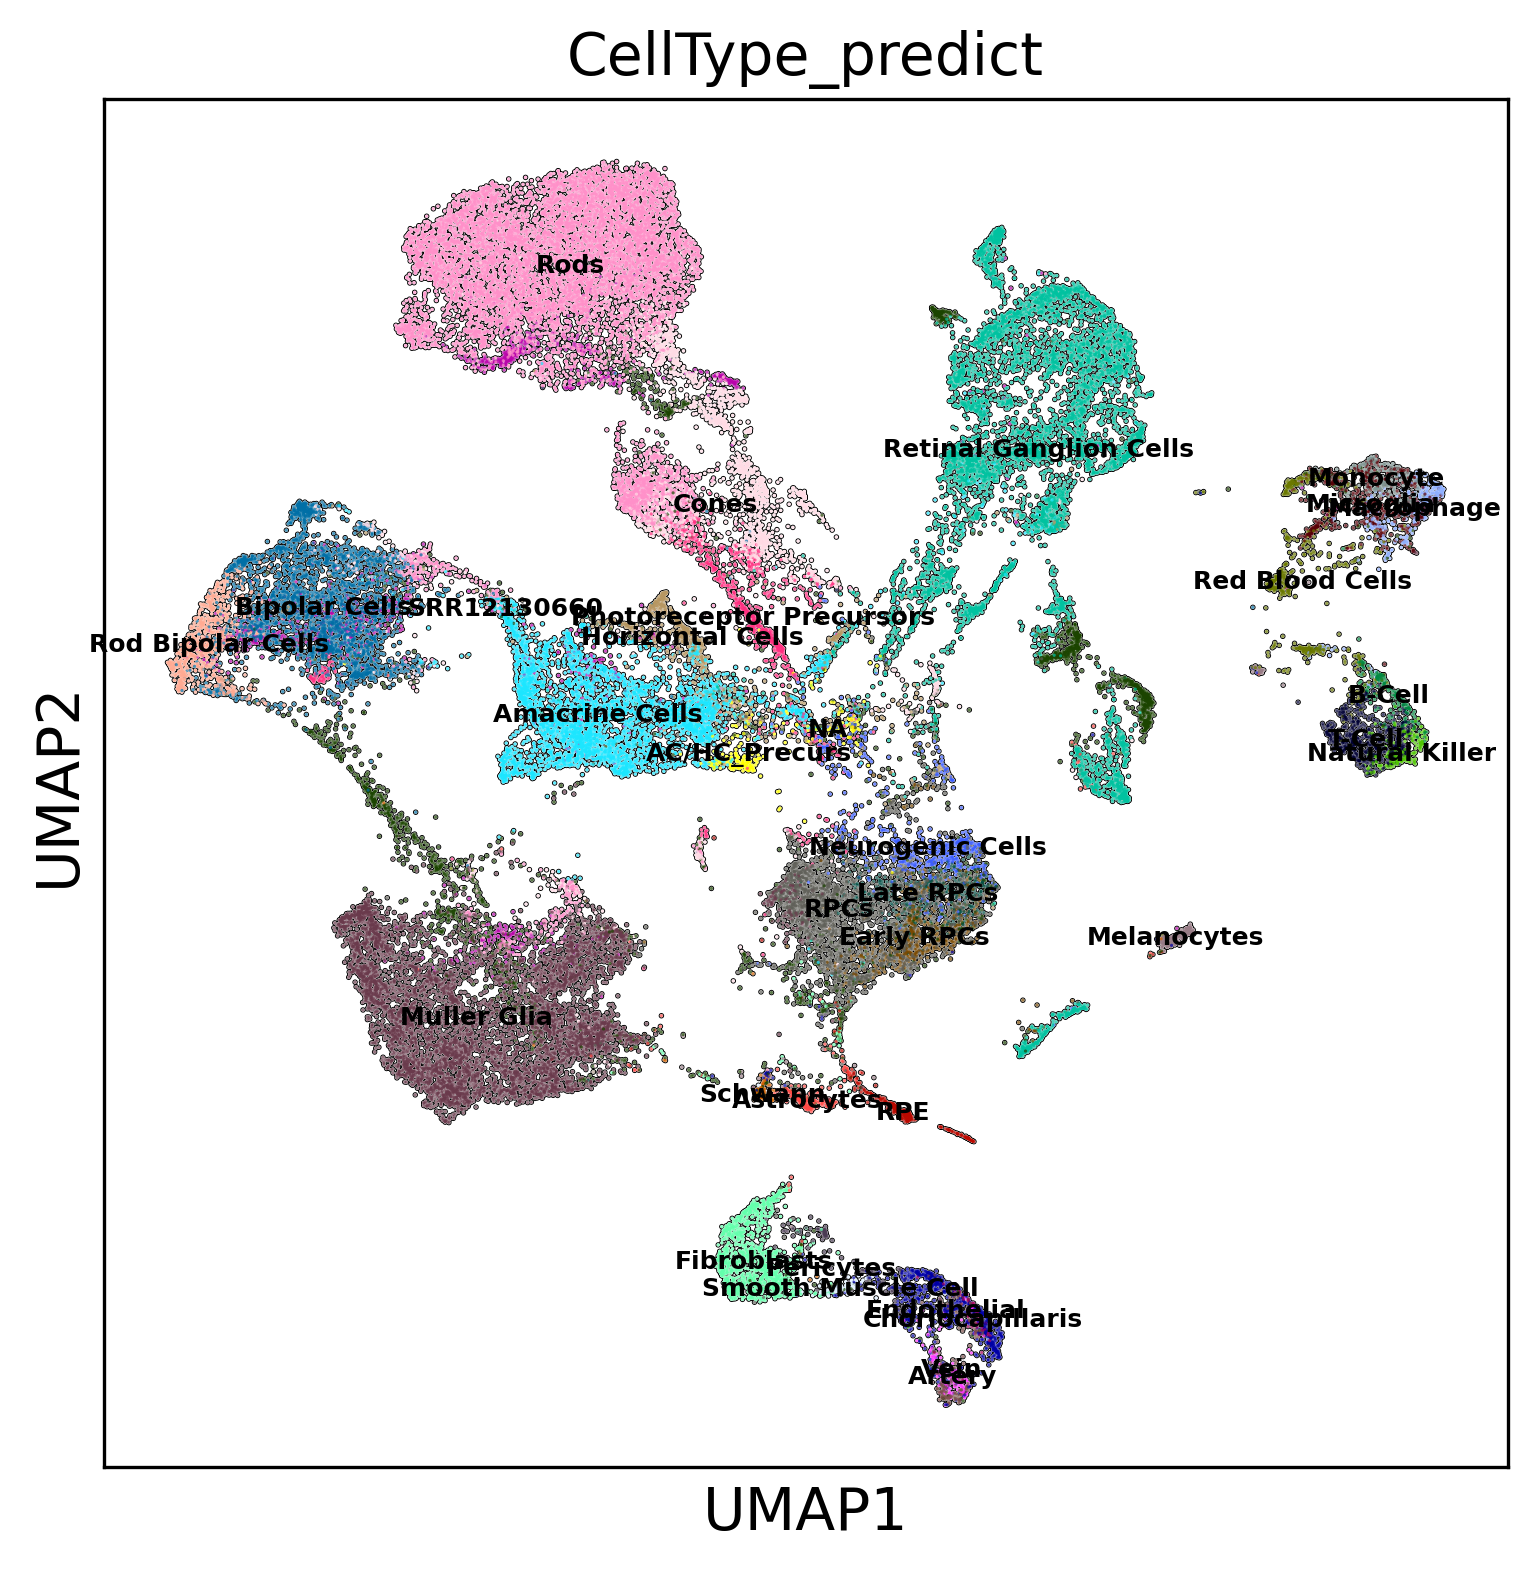

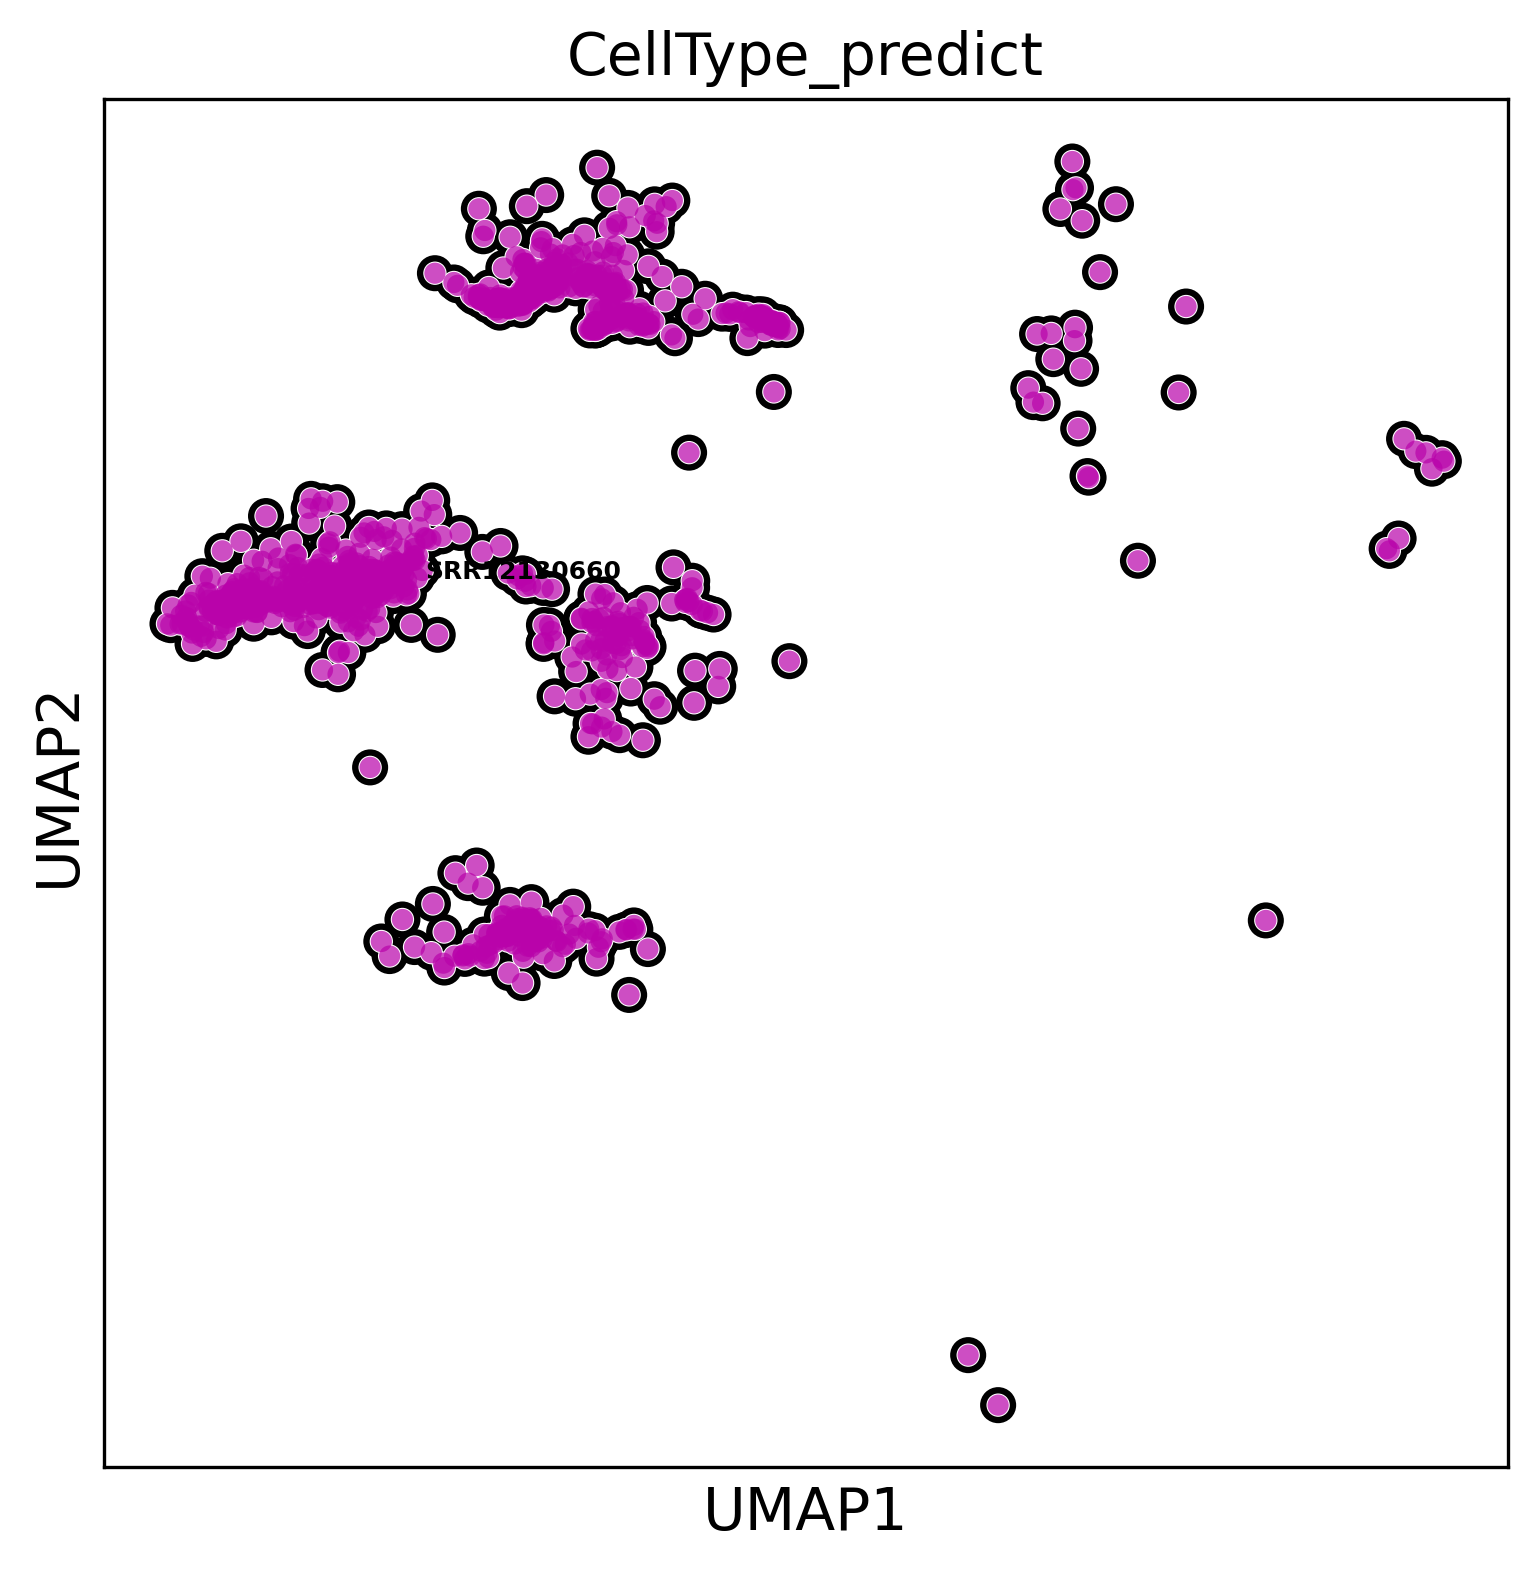

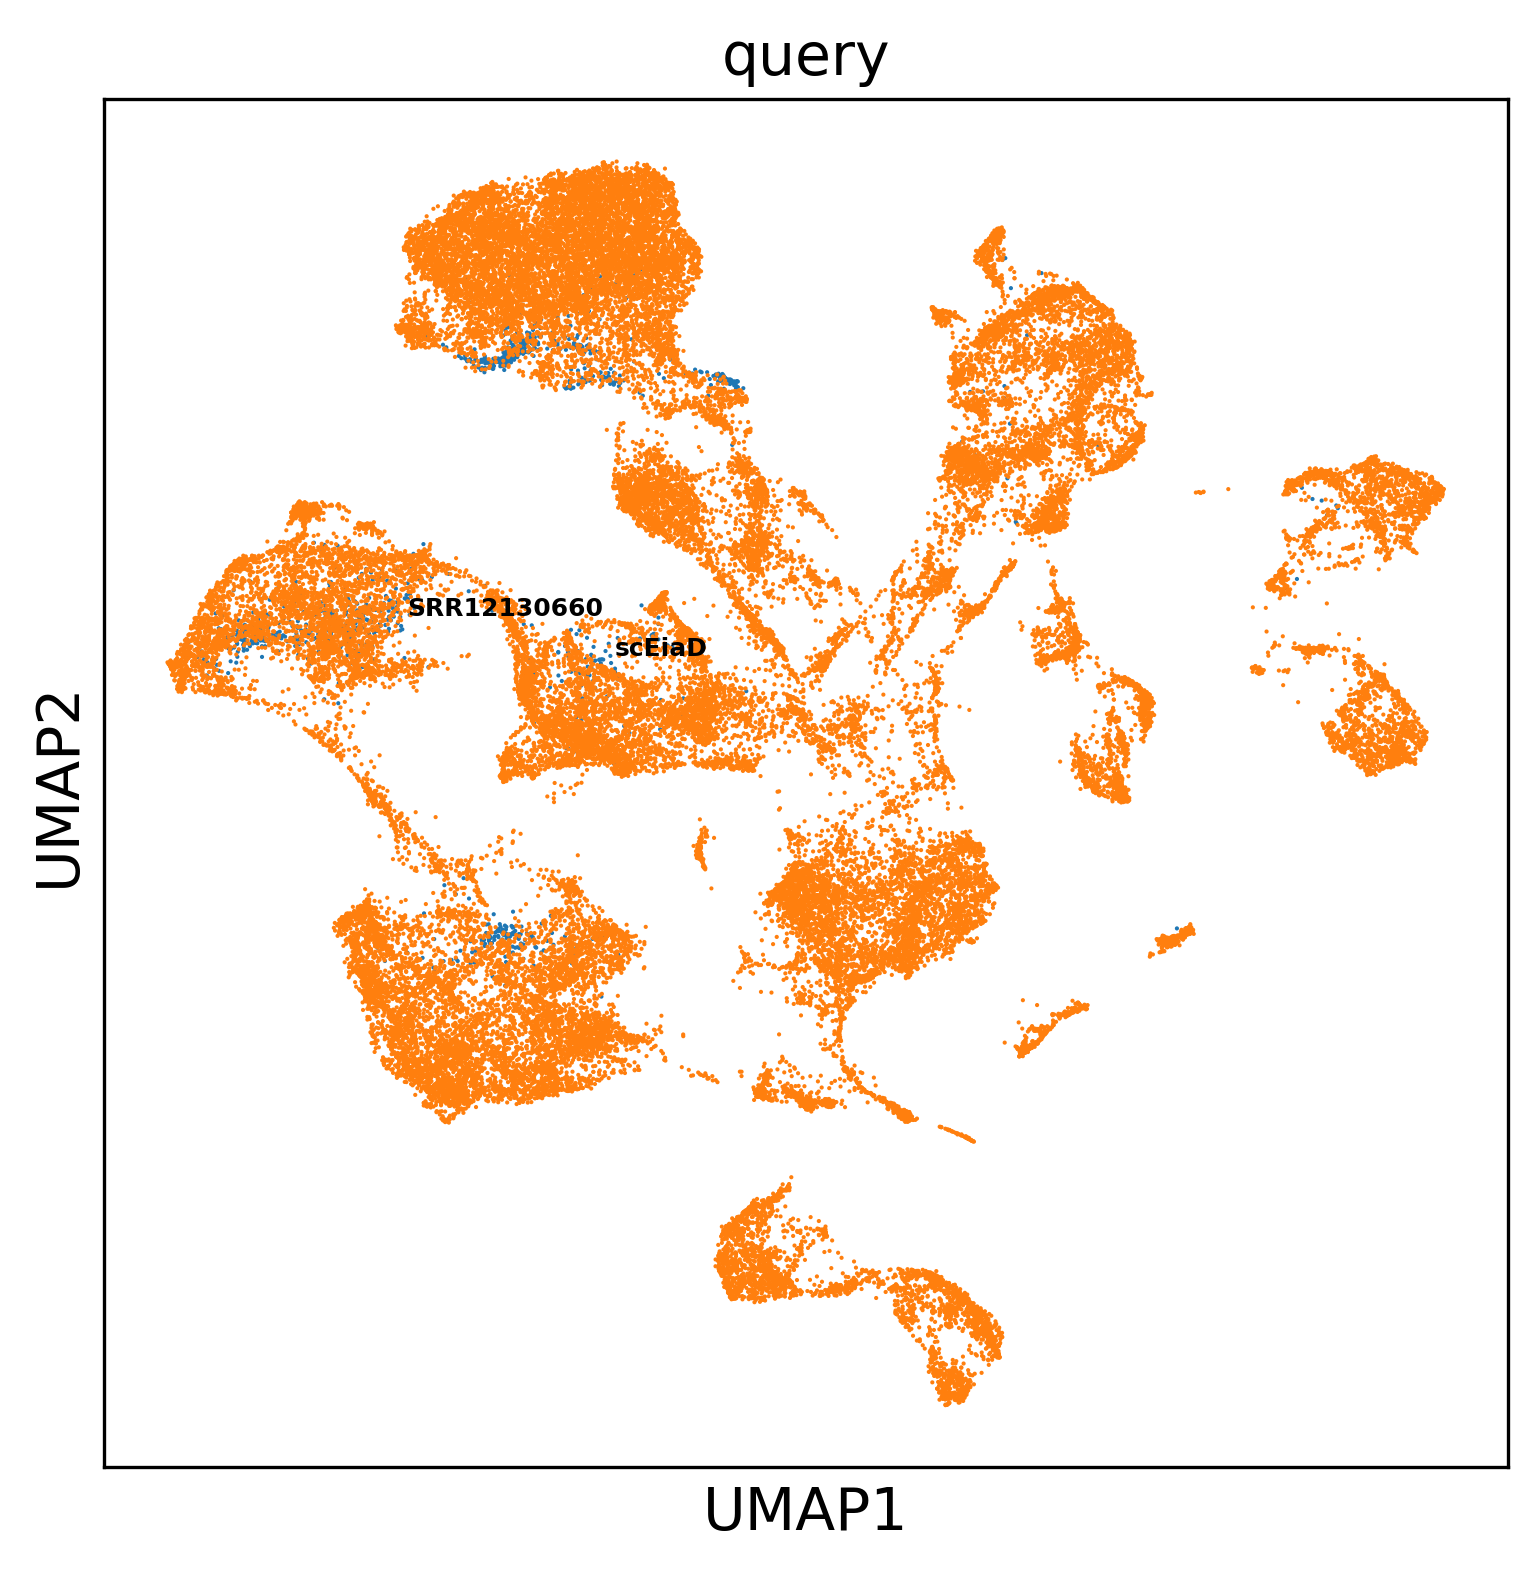

In [14]:
from matplotlib import rcParams
sc.set_figure_params(dpi=150)
rcParams['figure.figsize'] = 6, 6
sc.pl.umap(adata_full_HVG, color = 'CellType_predict', add_outline=True, legend_loc='on data',  legend_fontsize=6)
sc.pl.umap(adata_full_HVG[adata_full_HVG.obs['query'] != 'scEiaD'], color = 'CellType_predict', add_outline=True, legend_loc='on data',  legend_fontsize=6)
sc.pl.umap(adata_full_HVG, color = 'query',legend_loc='on data', legend_fontsize=6, size = 4)